# Proyecto Prophet 

Vamos a crear un modelo con el fin de predecir la demanda de una ruta encargada de entregar producto en la ciudad de Medellín, para esto tenemos un gran dataset con muchos productos y varias rutas, vamos a seleccionar solo una ruta en este caso y a partir de estos elaborar el análisis

## Importación de librerías 

Importamos las librerías necesarias, necesitamos tener instalado prophet, éste a veces puede traer problemas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

import sys
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import preprocessing
from fbprophet import Prophet

sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

## Carga de datos

Todos los datos están en un archivo único que hemos ubicado en una carpeta local llamada datos.

In [2]:
datos_dsd=pd.read_csv('Datos\DSDJourneyInput.csv',sep=',')

## Limpieza de datos

Limpiamos los datos, es decir aseguramos un formato de datos específico para ciertas columnasa, renombrar con nombres más entendibles, asegurar la ausencia de datos duplicados, usar solo las columnas que nos interesan, arreglar formato de datos, asegurar el uso de datos completos y ordenar los datos

In [3]:
datos_dsd_limpio=datos_dsd.rename(columns={'SkJourney':'SKU Journey'
                                           ,'CartonUnits':'Cartones producto'
                                           ,'JourneyCode':'Código journey'
                                           ,'Movementtypecode':'Tipo movimiento'
                                           ,'MovementCode':'Código movimiento'
                                           ,'JourneyStartDateTime':'Inicio Journey real'
                                           ,'JourneyPlannedStartDateTime':'Inicio Journey planeado'
                                           ,'ProductCode':'Código producto'
                                           ,'ProductDescription':'Descripción producto'
                                           ,'MovementDate':'Fecha movimiento'
                                           ,'CantVisitasPlanedas':'Visitas planeadas'
                                           ,'CantVisitasNoPlaneadas':'Visitas no planeadas'
                                           ,'RecordLoadedOn':'Carga del registro'
                                           ,'Rout':'Ruta'})
datos_dsd_limpio[['Cartones producto']]=datos_dsd_limpio[['Cartones producto']].astype(float)
datos_dsd_limpio[['Código journey']]=datos_dsd_limpio[['Código journey']].astype(str)
datos_dsd_limpio[['Código movimiento']]=datos_dsd_limpio[['Código movimiento']].astype(str)
datos_dsd_limpio[['Visitas planeadas']]=datos_dsd_limpio[['Visitas planeadas']].astype(int)
datos_dsd_limpio[['Visitas no planeadas']]=datos_dsd_limpio[['Visitas no planeadas']].astype(int)
datos_dsd_limpio['Inicio Journey real']=pd.to_datetime(pd.to_datetime(datos_dsd_limpio['Inicio Journey real'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d'))
datos_dsd_limpio['Inicio Journey planeado']=pd.to_datetime(pd.to_datetime(datos_dsd_limpio['Inicio Journey planeado'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d'))
datos_dsd_limpio=datos_dsd_limpio.drop(columns=['SKU Journey'])
datos_dsd_limpio=datos_dsd_limpio.dropna(subset=['Código journey','Descripción producto','Cartones producto'],how='any')
datos_dsd_limpio=datos_dsd_limpio.drop_duplicates()
datos_dsd_limpio['Tipo movimiento']=datos_dsd_limpio['Tipo movimiento'].str.strip()
datos_dsd_limpio=datos_dsd_limpio.sort_values(by=['Inicio Journey planeado'])

## Procesamiento de datos

### Selección de ruta

Seleccionamos una sola ruta de las 6 que hay en el dataset, en particular usaremos la que posea más datos

In [4]:
rutas=np.unique(datos_dsd_limpio['Ruta'],return_counts=True)

In [5]:
rutas

(array(['CO4103', 'CO4108', 'CO4110', 'CO4112', 'CO4113', 'CO4152'],
       dtype=object),
 array([69797, 76736, 73791, 73150, 76750, 47179], dtype=int64))

In [6]:
datos_dsd_limpio_ruta=datos_dsd_limpio.loc[datos_dsd_limpio['Ruta']=='CO4103'].reset_index(drop=True)

### Estructuras de los datos planos

Visualizamos el dataset que hemos preparado hasta el momento

In [7]:
datos_dsd_limpio_ruta

,Cartones producto,Código journey,Tipo movimiento,Código movimiento,Inicio Journey real,Inicio Journey planeado,Código producto,Descripción producto,Fecha movimiento,Visitas planeadas,Visitas no planeadas,Carga del registro,Ruta
0,1.1,97173,JFROMVAN,211634,2015-01-13,2015-01-13,FA033963.06,MARLBORO ICE XPRESS MNT KS BOX 20,2015-01-13 00:00:00,53,2,2021-03-31 17:31:52.363,CO4103
1,3.6,97173,JFROMVAN,211634,2015-01-13,2015-01-13,FA033942.05,MARLBORO ICE XPRESS MNT KS BOX 10,2015-01-13 00:00:00,53,2,2021-03-31 17:31:52.363,CO4103
2,7.0,97173,JFROMVAN,211634,2015-01-13,2015-01-13,FA038854.06,GREEN (WHITE) MNT KS BOX 10,2015-01-13 00:00:00,53,2,2021-03-31 17:31:52.363,CO4103
3,0.6,97173,JFROMVAN,211634,2015-01-13,2015-01-13,FA029190.06,MARLBORO (RED UPGRADE) KS BOX 10,2015-01-13 00:00:00,53,2,2021-03-31 17:31:52.363,CO4103
4,1.0,97173,JFROMVAN,211634,2015-01-13,2015-01-13,FA038855.06,GREEN MENTHOL MNT KS BOX 10,2015-01-13 00:00:00,53,2,2021-03-31 17:31:52.363,CO4103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69792,1.0,867316,JLOAD,1377346,2021-09-11,2021-09-11,FA077009.01,MARLBORO FOREST FUSION MNT KS BOX 10,2021-09-10 10:21:00,34,2,2021-09-14 16:30:59.527,CO4103
69793,4.0,867316,JLOAD,1377054,2021-09-11,2021-09-11,FA077007.03,MARLBORO SUMMER FUSION MNT KS BOX 20,2021-09-10 00:00:00,34,2,2021-09-14 16:30:59.527,CO4103
69794,44.0,867316,JLOAD,1377054,2021-09-11,2021-09-11,FA076113.02,CHESTERFIELD BLUE (4.0) KS BOX 20,2021-09-10 00:00:00,34,2,2021-09-14 16:30:59.527,CO4103
69795,47.0,867316,JLOAD,1377054,2021-09-11,2021-09-11,FA068569.06,CHESTERFIELD GREENRE4 MNT KS BOX 10,2021-09-10 00:00:00,34,2,2021-09-14 16:30:59.527,CO4103


In [8]:
datos_dsd_limpio_ruta.columns

Index(['Cartones producto', 'Código journey', 'Tipo movimiento',
       'Código movimiento', 'Inicio Journey real', 'Inicio Journey planeado',
       'Código producto', 'Descripción producto', 'Fecha movimiento',
       'Visitas planeadas', 'Visitas no planeadas', 'Carga del registro',
       'Ruta'],
      dtype='object')

In [9]:
datos_dsd_limpio_ruta.dtypes

Cartones producto                 float64
Código journey                     object
Tipo movimiento                    object
Código movimiento                  object
Inicio Journey real        datetime64[ns]
Inicio Journey planeado    datetime64[ns]
Código producto                    object
Descripción producto               object
Fecha movimiento                   object
Visitas planeadas                   int32
Visitas no planeadas                int32
Carga del registro                 object
Ruta                               object
dtype: object

### Formato de datos 

Extraemos información relevante de los datos

In [10]:
datos_dsd_carga=datos_dsd_limpio_ruta.loc[datos_dsd_limpio_ruta['Tipo movimiento']=='JLOAD']
datos_dsd_descarga=datos_dsd_limpio_ruta.loc[datos_dsd_limpio_ruta['Tipo movimiento']=='JFROMVAN']

In [11]:
cigarrillos=np.unique(datos_dsd_limpio_ruta['Descripción producto'])
productos_ruta_individuales_carga=[]
productos_ruta_individuales_descarga=[]
for producto in cigarrillos:
    productos_ruta_individuales_carga.append(datos_dsd_carga.loc[datos_dsd_carga['Descripción producto']==producto].sort_values(by=['Inicio Journey planeado']).reset_index(drop=True))
    productos_ruta_individuales_descarga.append(datos_dsd_descarga.loc[datos_dsd_descarga['Descripción producto']==producto].sort_values(by=['Inicio Journey planeado']).reset_index(drop=True))

Creamos un dataset por producto

In [12]:
productos_ruta_individuales_carga_agrupado=[]
productos_ruta_individuales_descarga_agrupado=[]
for j in range(len(productos_ruta_individuales_carga)):
    productos_ruta_individuales_carga_agrupado.append(pd.merge(productos_ruta_individuales_carga[j][['Código journey','Inicio Journey planeado','Descripción producto','Visitas planeadas','Visitas no planeadas']],productos_ruta_individuales_carga[j].groupby(by=['Inicio Journey planeado'])[['Inicio Journey planeado','Cartones producto']].sum().reset_index(),on=['Inicio Journey planeado'],how='inner').drop_duplicates(subset=['Código journey']))
    productos_ruta_individuales_descarga_agrupado.append(pd.merge(productos_ruta_individuales_carga[j][['Código journey','Inicio Journey planeado','Descripción producto','Visitas planeadas','Visitas no planeadas']],productos_ruta_individuales_descarga[j].groupby(by=['Inicio Journey planeado'])[['Inicio Journey planeado','Cartones producto']].sum().reset_index(),on=['Inicio Journey planeado'],how='inner').drop_duplicates(subset=['Código journey']))

In [13]:
productos_ruta_individuales_total=[]
for j in range(len(productos_ruta_individuales_carga)):
    productos_ruta_individuales_total.append(pd.merge(productos_ruta_individuales_carga_agrupado[j].rename(columns={'Cartones producto':'Cartones carga'}),productos_ruta_individuales_descarga_agrupado[j][['Inicio Journey planeado','Cartones producto']].rename(columns={'Cartones producto':'Cartones descarga'}),on=['Inicio Journey planeado'],how='inner').sort_values(by=['Inicio Journey planeado']))
    productos_ruta_individuales_total[j]['Venta estimada']=productos_ruta_individuales_total[j]['Cartones carga']-productos_ruta_individuales_total[j]['Cartones descarga']

## Análisis exploratorio de datos

Tomamos variables indirectas y dejamos solo los productos con datos adecuados

### Variables indirectas

In [14]:
for j in range(len(productos_ruta_individuales_total)):
    productos_ruta_individuales_total[j]['Año journey']=pd.DatetimeIndex(productos_ruta_individuales_total[j]['Inicio Journey planeado']).year

### Análisis de cantidad de datos

In [15]:
productos_individuales_año_ruta=[]
for j in range(len(productos_ruta_individuales_total)):
    productos_individuales_año_ruta.append(productos_ruta_individuales_total[j].loc[productos_ruta_individuales_total[j]['Inicio Journey planeado']>=dt.datetime(2021,5,1)])
productos_individuales_año_ruta_vigente=list(filter(lambda df: not df.empty, productos_individuales_año_ruta))
productos_año_ruta_vigentes=np.unique(pd.concat(productos_individuales_año_ruta_vigente,axis=0)['Descripción producto'])

In [16]:
producto_individuales_total_vigentes=[]
for j in range(len(productos_ruta_individuales_total)):
    producto_individuales_total_vigentes.append(productos_ruta_individuales_total[j].loc[productos_ruta_individuales_total[j]['Descripción producto'].isin(productos_año_ruta_vigentes)])
producto_individuales_filtrado=list(filter(lambda df: not df.empty, producto_individuales_total_vigentes))


### Procesamiento y filtro de datos

Creamos los filtros

In [17]:
productos_cantidad_cargue=[]
productos_cantidad_ventas=[]
productos_suma_cargue=[]
productos_suma_ventas=[]
productos_media_cargue=[]
productos_media_ventas=[]

for j in range(len(producto_individuales_filtrado)):
    productos_cantidad_cargue.append([np.unique(producto_individuales_filtrado[j]['Descripción producto'])[0],producto_individuales_filtrado[j]['Inicio Journey planeado'].iloc[-1],len(producto_individuales_filtrado[j].loc[(producto_individuales_filtrado[j]['Inicio Journey planeado']>=dt.datetime(2021,5,1))])])
    productos_cantidad_ventas.append(len(producto_individuales_filtrado[j].loc[(producto_individuales_filtrado[j]['Inicio Journey planeado']>=dt.datetime(2021,5,1))&(producto_individuales_filtrado[j]['Venta estimada']>0)]))
    productos_suma_cargue.append(np.sum(producto_individuales_filtrado[j].loc[(producto_individuales_filtrado[j]['Inicio Journey planeado']>=dt.datetime(2021,5,1))]['Cartones carga']))
    productos_suma_ventas.append(np.sum(producto_individuales_filtrado[j].loc[(producto_individuales_filtrado[j]['Inicio Journey planeado']>=dt.datetime(2021,5,1))]['Venta estimada']))
    productos_media_cargue.append(np.mean(producto_individuales_filtrado[j].loc[(producto_individuales_filtrado[j]['Inicio Journey planeado']>=dt.datetime(2021,5,1))]['Cartones carga']))
    productos_media_ventas.append(np.mean(producto_individuales_filtrado[j].loc[(producto_individuales_filtrado[j]['Inicio Journey planeado']>=dt.datetime(2021,5,1))]['Venta estimada']))
datos_filtro_productos=pd.DataFrame(productos_cantidad_cargue,columns=['Producto','Fecha ultima venta','Cantidad de cargues'])
datos_filtro_productos['Cantidad veces vendido']=productos_cantidad_ventas
datos_filtro_productos['Producto cargado total']=productos_suma_cargue
datos_filtro_productos['Producto vendido total']=productos_suma_ventas
datos_filtro_productos['Producto medio cargado total']=productos_media_cargue
datos_filtro_productos['Producto medio vendido total']=productos_media_ventas
datos_filtro_productos['Veces venta mínima']=np.ceil(((datos_filtro_productos['Fecha ultima venta'] - dt.datetime(2021,5,1)).dt.days)/7).astype(np.int64)
datos_filtro_productos['Veces cargue mínimo']=2*np.ceil(((datos_dsd_limpio['Inicio Journey planeado'].iloc[-1] - dt.datetime(2021,5,1)).days)/7).astype(np.int64)

productos_condicion_filtro=datos_filtro_productos.loc[(datos_filtro_productos['Cantidad veces vendido']>datos_filtro_productos['Veces venta mínima'])&(datos_filtro_productos['Cantidad de cargues']>datos_filtro_productos['Veces cargue mínimo'])].reset_index(drop=True)
productos_finales=productos_condicion_filtro['Producto']

In [18]:
productos_condicion_filtro

,Producto,Fecha ultima venta,Cantidad de cargues,Cantidad veces vendido,Producto cargado total,Producto vendido total,Producto medio cargado total,Producto medio vendido total,Veces venta mínima,Veces cargue mínimo
0,CHESTERFIELD BLUE (4.0) KS BOX 10,2021-09-11,100,86,6311.1,3302.8,63.111000,33.028000,19,38
1,CHESTERFIELD BLUE (4.0) KS BOX 20,2021-09-11,100,86,2806.5,1457.4,28.065000,14.574000,19,38
2,CHESTERFIELD GREENRE4 MNT KS BOX 10,2021-09-11,100,85,2789.4,1301.6,27.894000,13.016000,19,38
3,CHESTERFIELD GREENRE4 MNT KS BOX 20,2021-09-11,99,84,994.6,410.8,10.046465,4.149495,19,38
4,CHESTERFIELD WHITE KS BOX 10,2021-09-11,100,86,5367.5,1952.0,53.675000,19.520000,19,38
5,CHESTERFIELD WHITE KS BOX 20,2021-09-11,100,84,1972.3,682.1,19.723000,6.821000,19,38
6,L&M PURPLE EVO MNT KS BOX 10,2021-09-11,99,72,783.3,342.5,7.912121,3.459596,19,38
7,L&M SILVER EVO KS BOX 10,2021-09-11,45,37,1021.9,386.0,22.708889,8.577778,19,38
8,L&M SILVER LABEL (5.0 CWB) KS BOX 10,2021-09-11,57,48,1041.7,495.5,18.275439,8.692982,19,38
9,L&M SILVER LABEL (5.0 CWB) KS BOX 20,2021-09-11,100,85,1086.7,377.7,10.867000,3.777000,19,38


In [19]:
producto_individuales_total_finales=[]
for j in range(len(producto_individuales_filtrado)):
    producto_individuales_total_finales.append(producto_individuales_filtrado[j].loc[producto_individuales_filtrado[j]['Descripción producto'].isin(productos_finales)])
producto_individuales_finales=list(filter(lambda df: not df.empty, producto_individuales_total_finales))


### Graficación de resultados resultantes

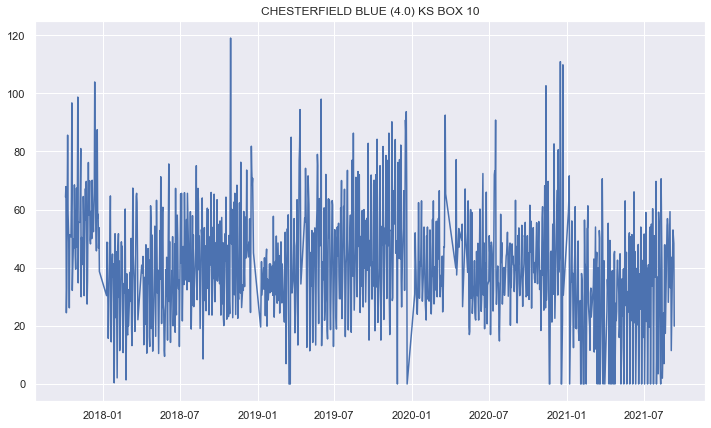

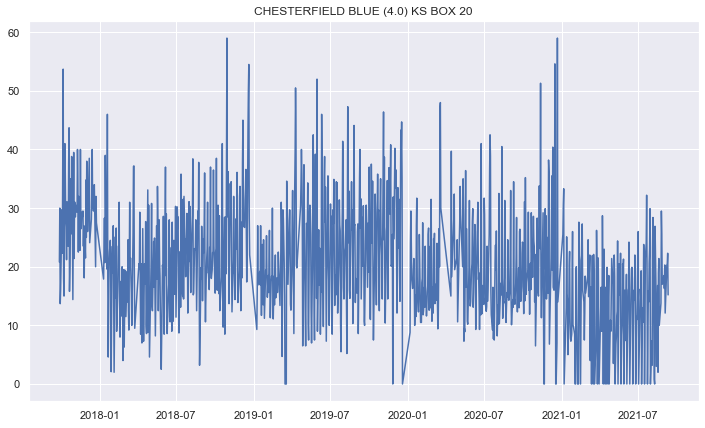

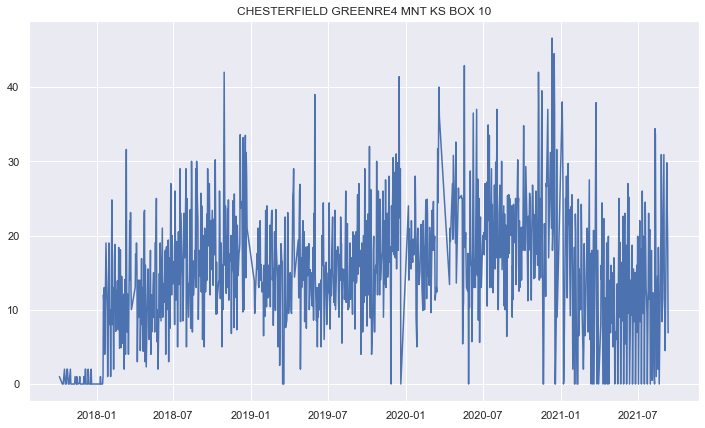

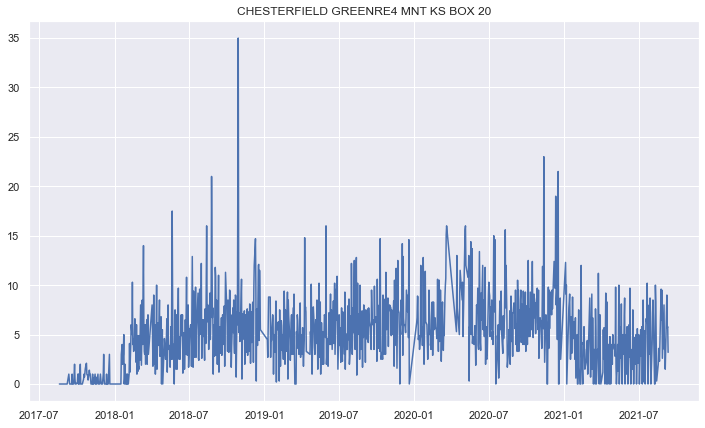

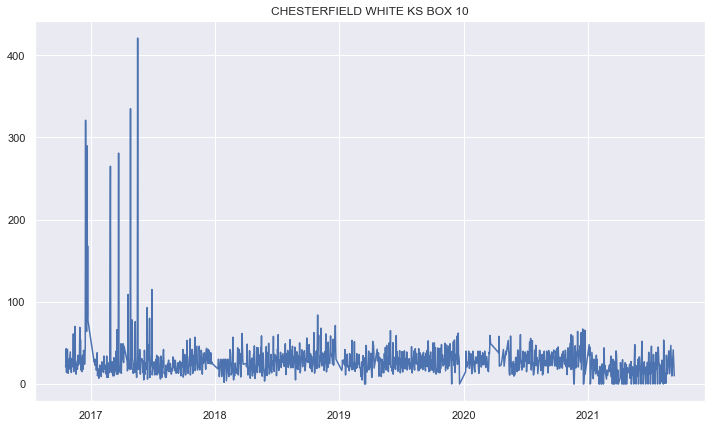

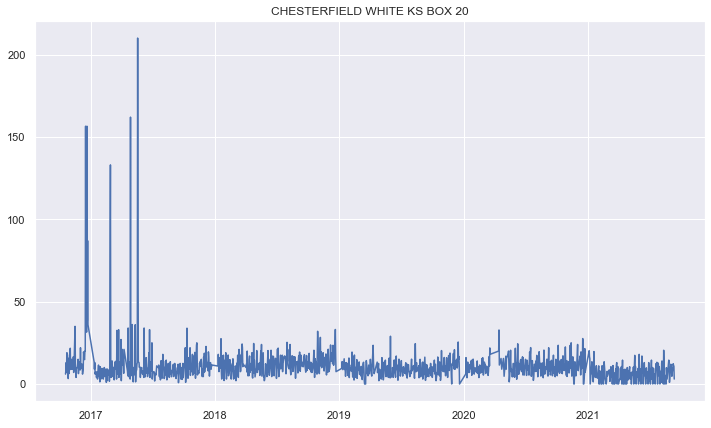

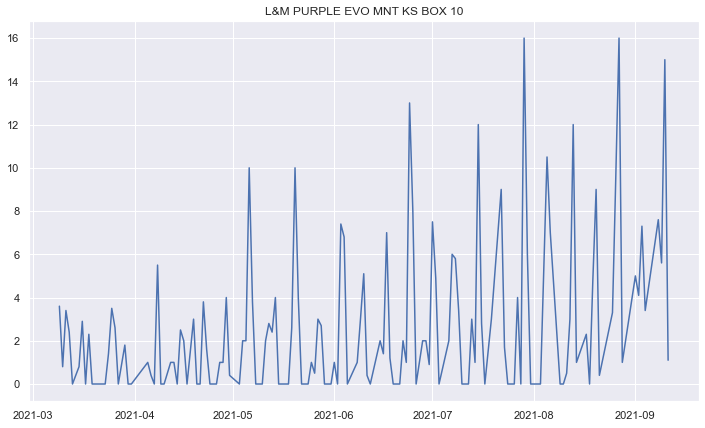

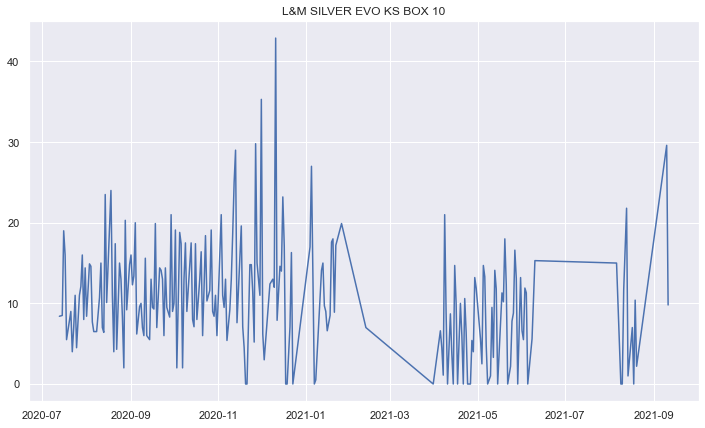

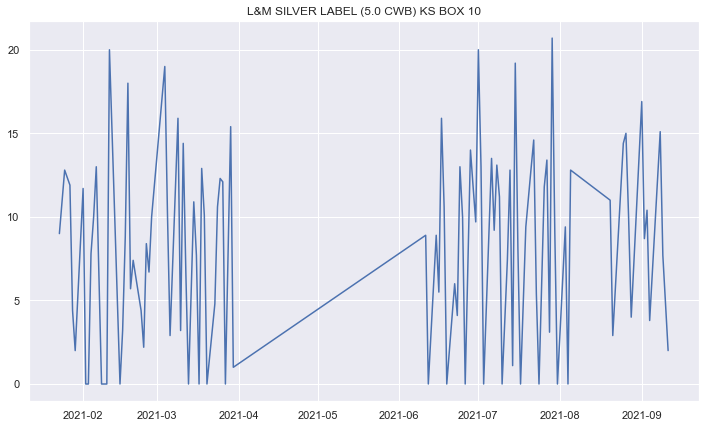

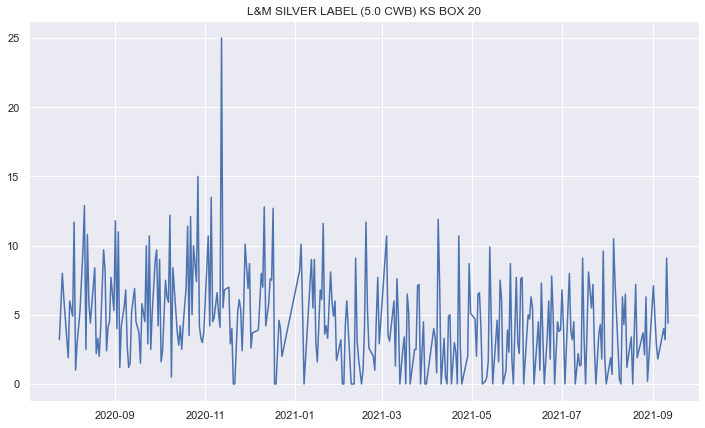

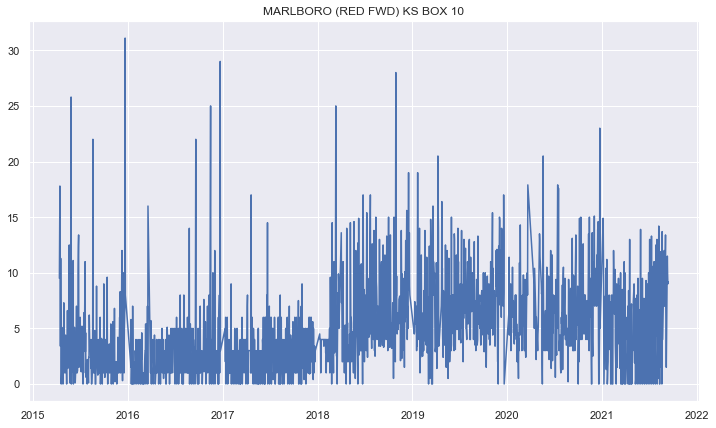

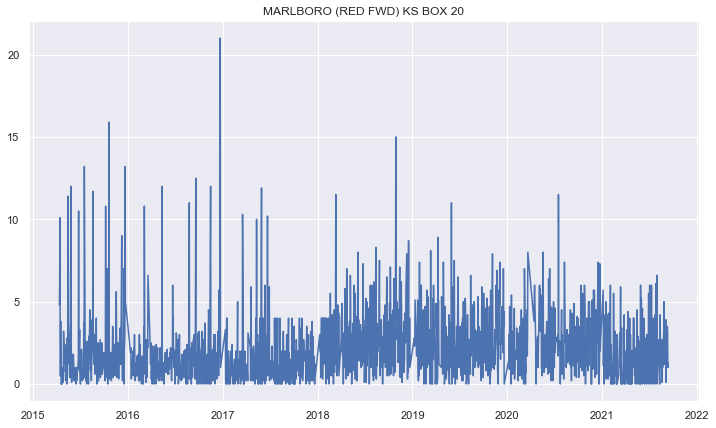

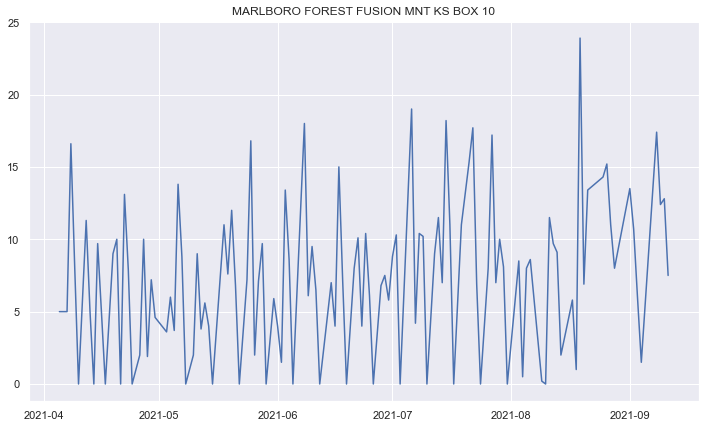

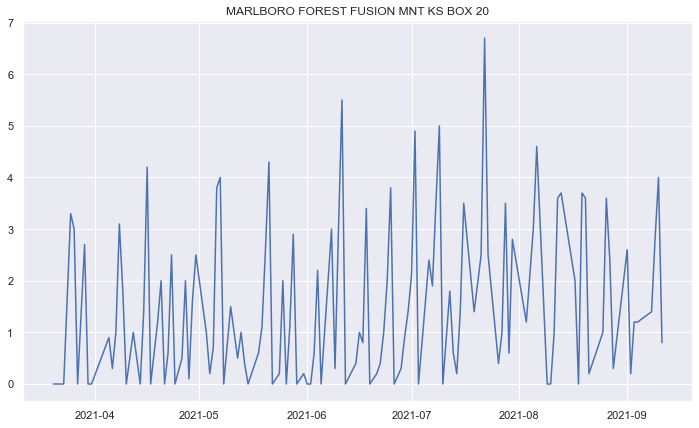

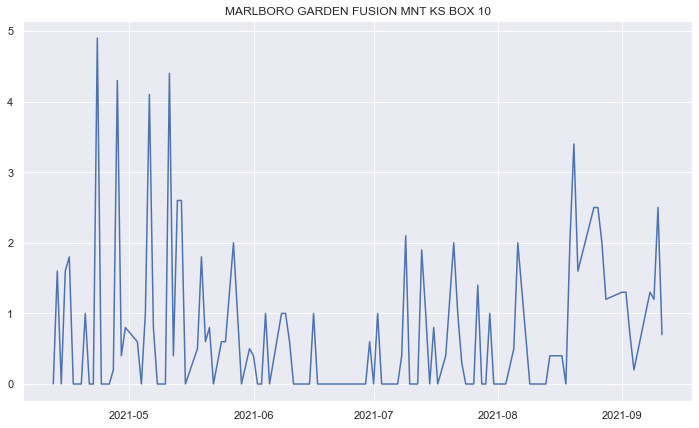

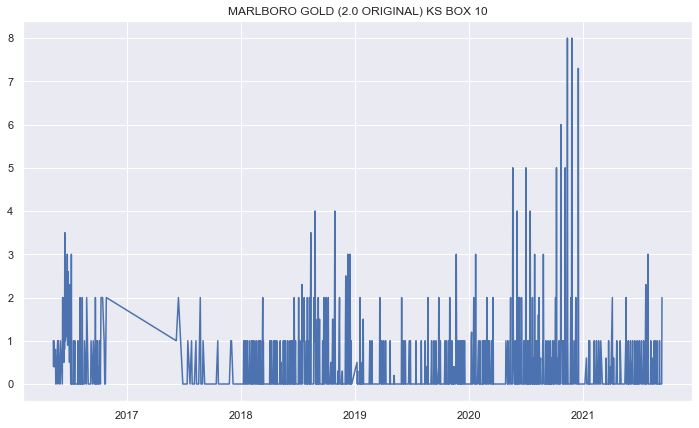

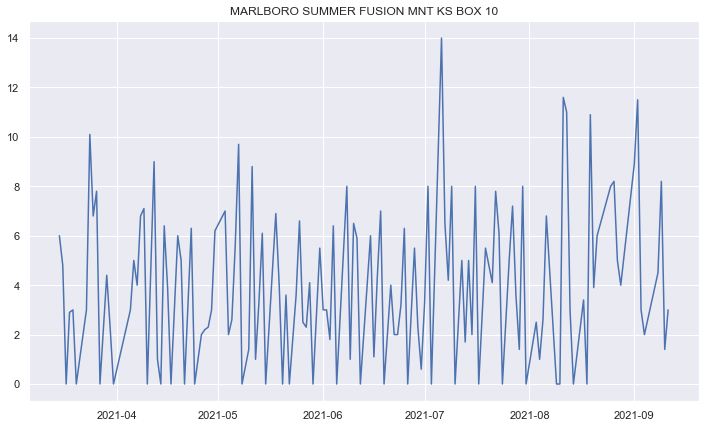

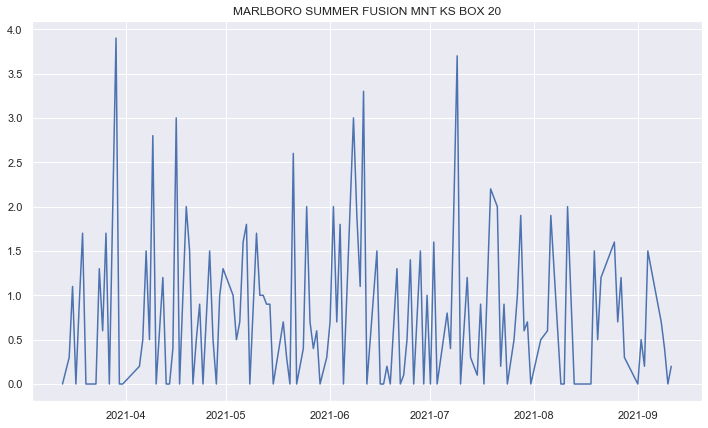

In [20]:
for i in range(len(producto_individuales_finales)):
    plt.figure(figsize=(12,7))
    plt.title(np.unique(producto_individuales_finales[i]['Descripción producto'])[0])
    plt.plot(producto_individuales_finales[i]['Inicio Journey planeado'],producto_individuales_finales[i]['Venta estimada'])

## Modelo

### Preparación de datos

#### Datos indirectos faltantes

In [21]:
for j in range(len(producto_individuales_finales)):
    producto_individuales_finales[j]['Dia de la semana']=producto_individuales_finales[j]['Inicio Journey planeado'].dt.dayofweek
    producto_individuales_finales[j]['Semana del año']=producto_individuales_finales[j]['Inicio Journey planeado'].dt.isocalendar().week
    producto_individuales_finales[j]['Mes del año']=producto_individuales_finales[j]['Inicio Journey planeado'].dt.month

#### Fechas especiales

In [22]:
especiales_dias=['01-01-2021','11-01-2021','22-03-2021','01-04-2021','02-04-2021','01-05-2021','17-05-2021','03-06-2021',
               '14-06-2021','05-07-2021','20-07-2021','07-08-2021','16-08-2021','18-10-2021','01-11-2021',
               '15-11-2021','08-12-2021','25-12-2021']

especiales_nombres=['Año nuevo','Dia de reyes','Dia de San Jose','Jueves Santo',
                'Viernes Santo','Dia del trabajo','Dia de la ascencion',
                'Corpues Christi','Sagrado corazon','Dia de la independencia',
                'Batalla de Boyaca','Asuncion de la virgen','Dia de la raza',
                'Dia de la raza','Todos los santos','Independencia de cartagena',
                'Inmaculada concepcion','Navidad']
especiales_datos=np.column_stack([especiales_dias,especiales_nombres])
especiales_datos_finales=pd.DataFrame(especiales_datos,columns=['ds','holiday'])
especiales_datos_finales['ds']=pd.to_datetime(pd.to_datetime(especiales_datos_finales['ds'],format='%d-%m-%Y').dt.strftime('%Y-%m-%d'),format='%Y-%m-%d')

#### Conjuntos de prueba y entrenamiento 

In [23]:
datos_preparados_prophet=[]
entrenamiento_prophet=[]
prueba_prophet=[]
completo_prophet=[]
for j in range(len(producto_individuales_finales)):
    datos_preparados_prophet.append(producto_individuales_finales[j][['Inicio Journey planeado','Venta estimada','Visitas planeadas']])
    datos_preparados_prophet[j].columns=['ds','y','Visitas planeadas']
    if max(datos_preparados_prophet[j]['y'])<=1:
        datos_preparados_prophet[j]['cap']=2
    else:
        datos_preparados_prophet[j]['cap']=max(datos_preparados_prophet[j]['y'])
    datos_preparados_prophet[j]['floor']=1
    entrenamiento_prophet.append(datos_preparados_prophet[j][(datos_preparados_prophet[j]['ds']>= max(datos_preparados_prophet[j]['ds'])-pd.DateOffset(months=3,weeks=1)) &(datos_preparados_prophet[j]['ds']<max(datos_preparados_prophet[j]['ds'])-pd.DateOffset(weeks=1))])
    prueba_prophet.append(datos_preparados_prophet[j][(datos_preparados_prophet[j]['ds']>= max(datos_preparados_prophet[j]['ds']-pd.DateOffset(weeks=1)))])

### Modelo de prophet

In [24]:
prediccion_modelo_productos=[]

for j in range(len(producto_individuales_finales)):
    modelo_prophet_individual=Prophet(growth='logistic',mcmc_samples=0,interval_width=0.9,changepoint_prior_scale=0.5,seasonality_mode='additive',seasonality_prior_scale=20,holidays=especiales_datos_finales,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False)
    #modelo_prophet_individual.add_seasonality(name='yearly',period=365,fourier_order=3)
    #modelo_prophet_individual.add_seasonality(name='monthly',period=30.5,fourier_order=6)
    modelo_prophet_individual.add_seasonality(name='weekly',period=7,fourier_order=20)
    modelo_prophet_individual.fit(entrenamiento_prophet[j])
    prediccion_modelo_productos.append(modelo_prophet_individual.predict(prueba_prophet[j][['ds','floor','cap','Visitas planeadas']]))

INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


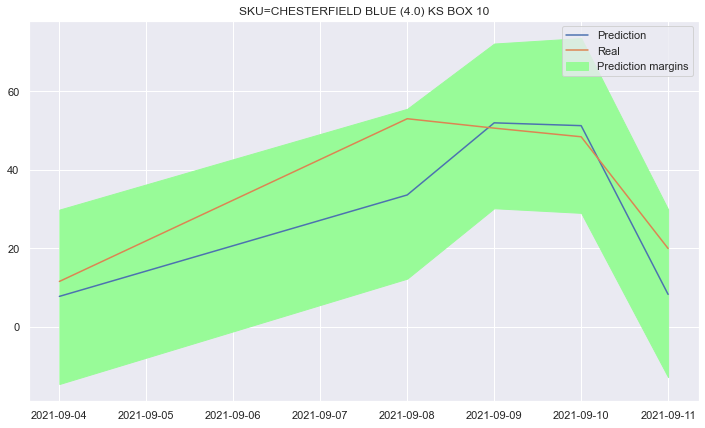

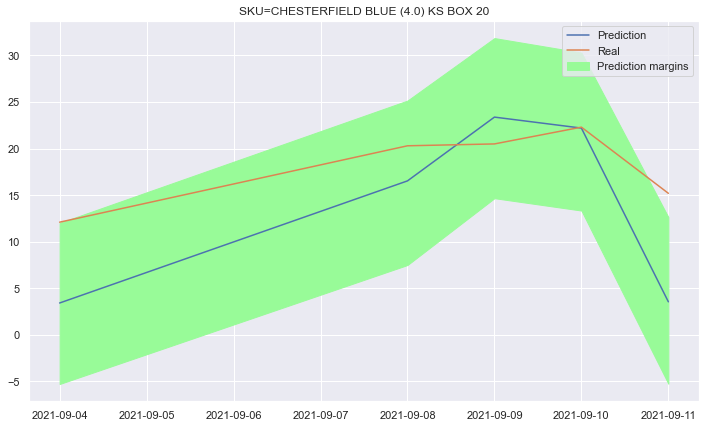

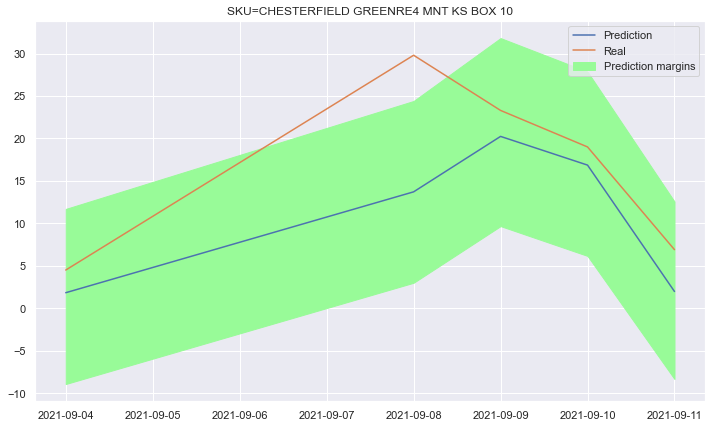

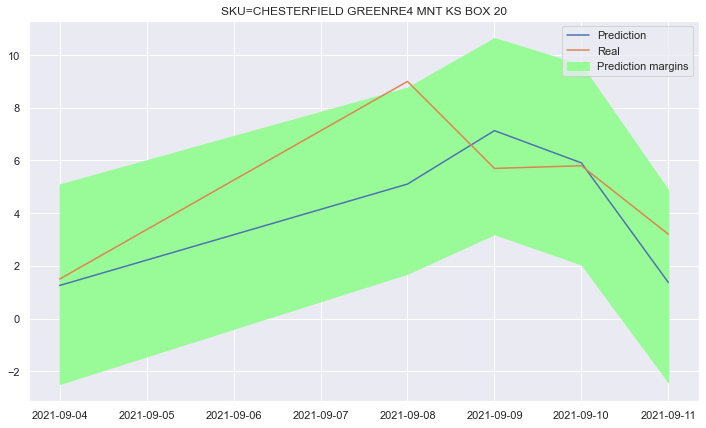

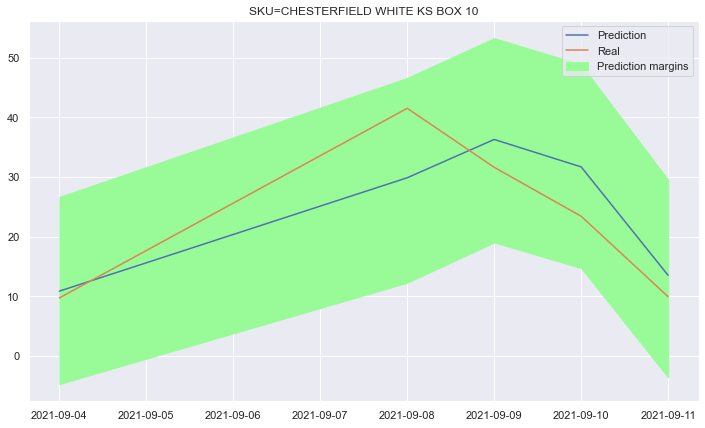

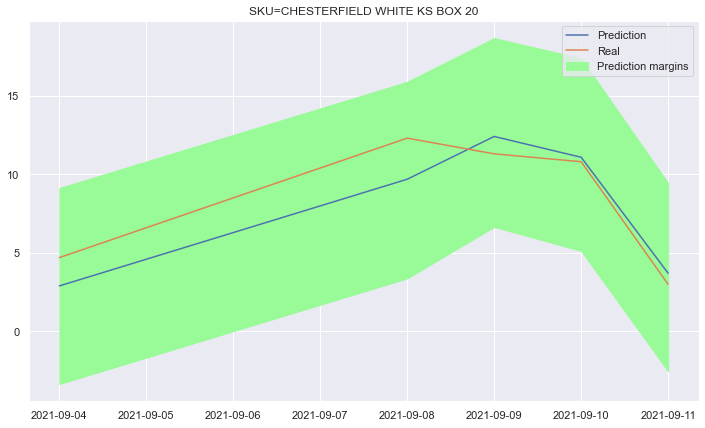

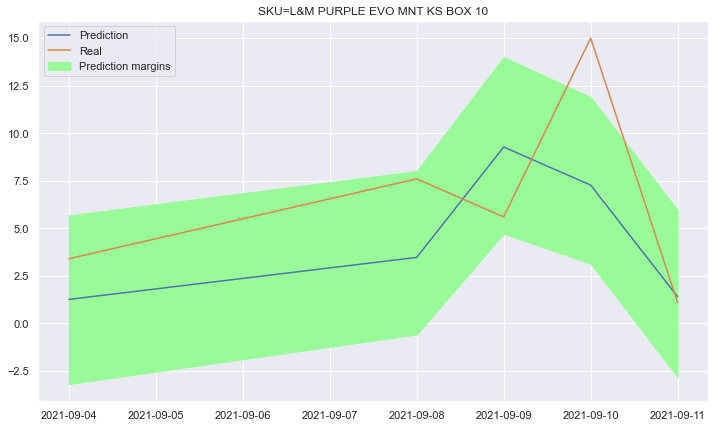

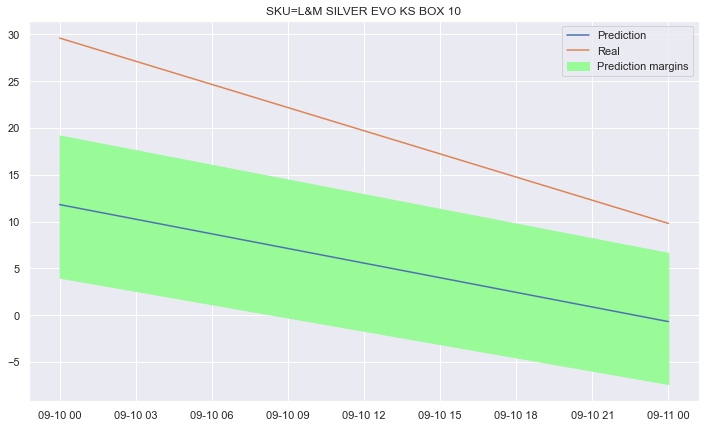

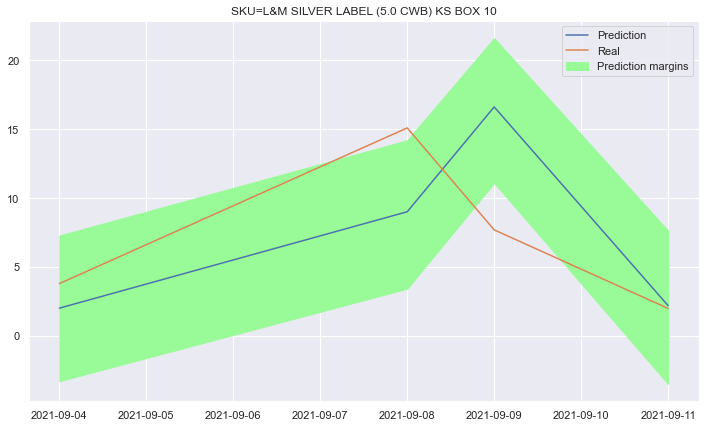

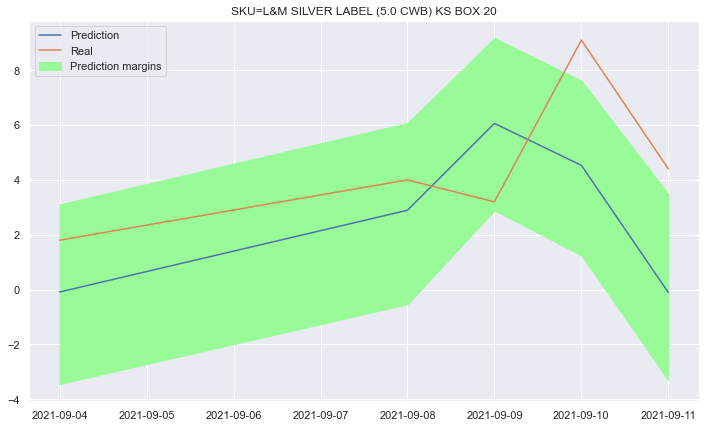

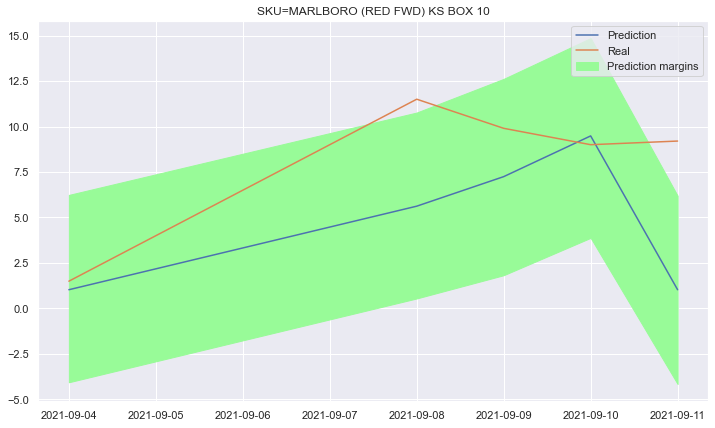

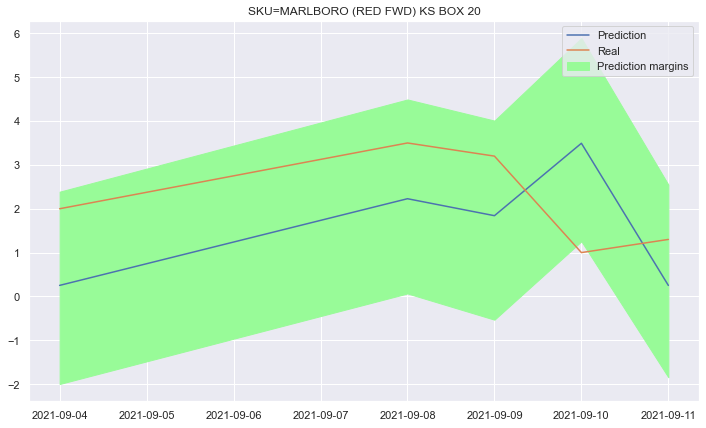

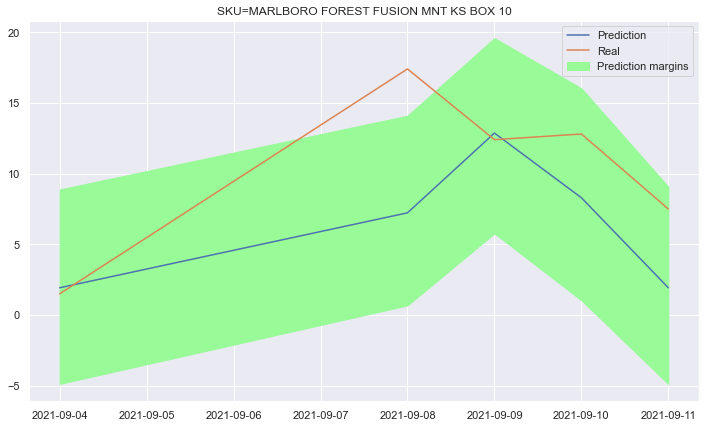

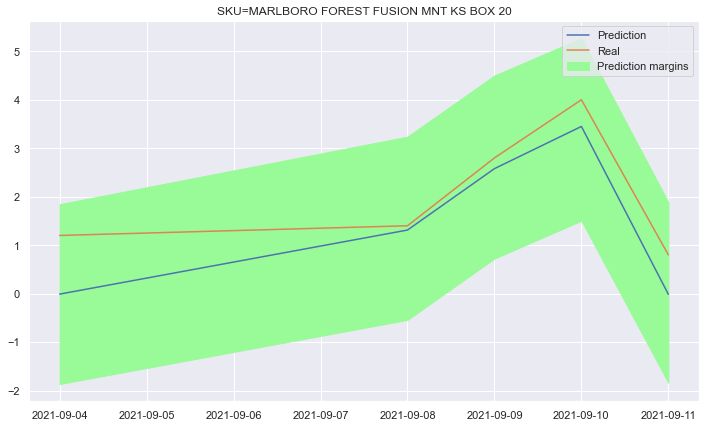

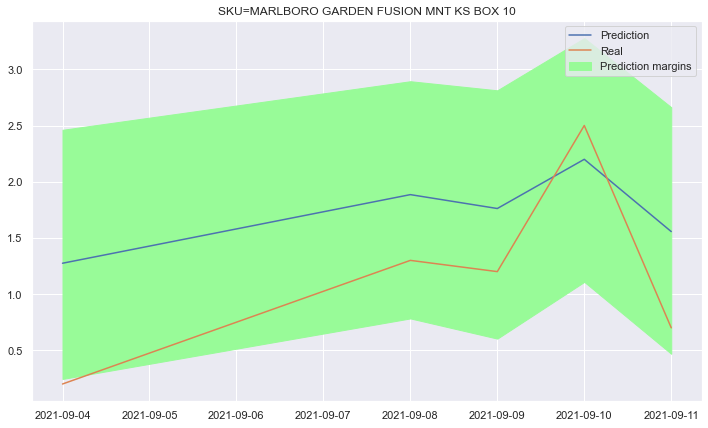

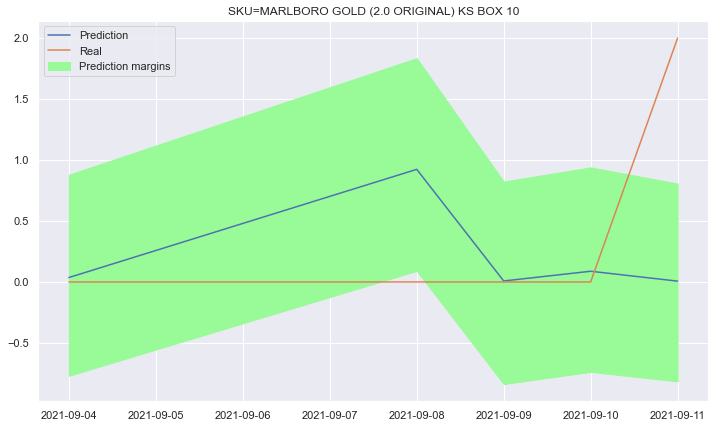

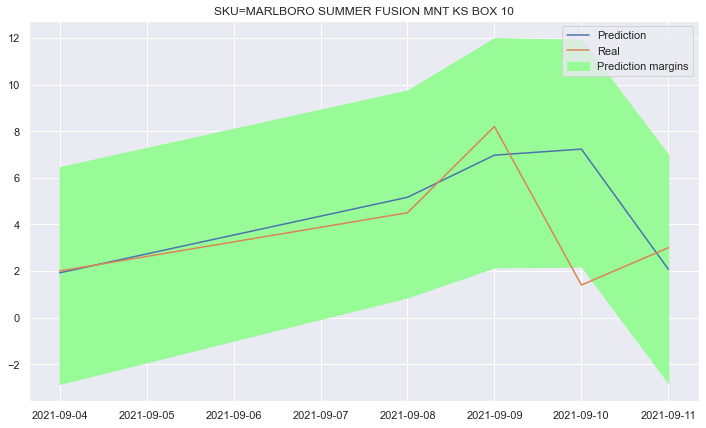

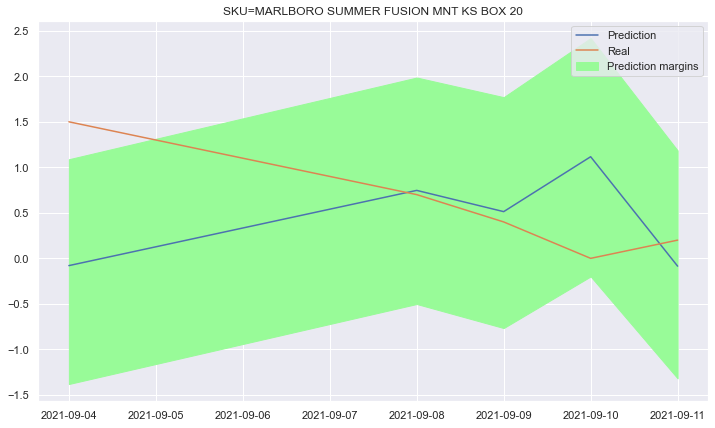

In [25]:
for i in range(len(prediccion_modelo_productos)):
    plt.figure(figsize=(12,7))
    plt.plot(prediccion_modelo_productos[i]['ds'],prediccion_modelo_productos[i]['yhat'],label='Prediction')
    plt.fill_between(prediccion_modelo_productos[i]['ds'],np.array(prediccion_modelo_productos[i]['yhat_lower'],dtype=float),np.array(prediccion_modelo_productos[i]['yhat_upper'],dtype=float),label='Prediction margins',color='palegreen')
    plt.plot(prueba_prophet[i]['ds'],prueba_prophet[i]['y'],label='Real')
    plt.title('SKU={}'.format(producto_individuales_finales[i]['Descripción producto'].unique()[0]))
    plt.legend()

## Errores

In [26]:
error_r2=[]
error_mse=[]
for i in range(len(prediccion_modelo_productos)):
    error_r2.append([r2_score(np.ceil(prueba_prophet[i]['y']),np.ceil(prediccion_modelo_productos[i]['yhat']),multioutput='variance_weighted'),np.unique(producto_individuales_finales[i]['Descripción producto'])[0]])
    error_mse.append([mean_squared_error(prueba_prophet[i]['y'],prediccion_modelo_productos[i]['yhat'],squared=False),np.unique(producto_individuales_finales[i]['Descripción producto'])[0]])
error_df=pd.DataFrame(error_r2,columns=['Porcentaje de acierto','SKU'])
error_df['Error en el producto medio (RMSE)']=np.array(error_mse)[:,0]
error_df=error_df[['SKU','Porcentaje de acierto','Error en el producto medio (RMSE)']]
error_df['Error en el producto medio (RMSE)']=error_df['Error en el producto medio (RMSE)'].astype(float).apply(np.ceil)
error_df['Porcentaje de acierto']=error_df['Porcentaje de acierto'].round(4)*100
error_df

,SKU,Porcentaje de acierto,Error en el producto medio (RMSE)
0,CHESTERFIELD BLUE (4.0) KS BOX 10,66.36,11.0
1,CHESTERFIELD BLUE (4.0) KS BOX 20,-263.37,7.0
2,CHESTERFIELD GREENRE4 MNT KS BOX 10,34.98,8.0
3,CHESTERFIELD GREENRE4 MNT KS BOX 20,37.50,3.0
4,CHESTERFIELD WHITE KS BOX 10,67.92,7.0
5,CHESTERFIELD WHITE KS BOX 20,80.20,2.0
6,L&M PURPLE EVO MNT KS BOX 10,15.00,5.0
7,L&M SILVER EVO KS BOX 10,-112.00,15.0
8,L&M SILVER LABEL (5.0 CWB) KS BOX 10,-3.48,6.0
9,L&M SILVER LABEL (5.0 CWB) KS BOX 20,-77.78,4.0
